# LocaleDB: Multivariate Time Series Clustering (Distance Matrices)
---

Clustering algorithms assign items to clusters based on pairwise distance metric such as the Euclidean distance.  A distance matrix is a square matrix that contains all pairwise distances among the items being clustered.  Visualizing distance matrices can provide insight into the structure of the data implied by the selected distance metric and can aid in interpretating clustering results.  This notebook demonstrates how to visualize distance matrices in the context of multivariate time series (MVTS) clustering.  The time series in question are Covid-19 disease dynamics (specifically daily counts of confirmed cases and deaths in US counties).

## Environment
---

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import multiprocessing as mp
import numpy as np
import os
import scipy.signal

from localedb.localedb import LocaleDB
from localedb.clustering import dist_mat, plot_dist_mat, plot_dist_mat_multi_col, plot_dist_mat_multi_row, plot_dist_mat_hist, plot_dist_mat_hist_multi_col, plot_dist_mat_hist_multi_row
from localedb.util import plot_init, plot_ts

db = LocaleDB().set_disease('COVID-19')

First, we declare variables and convenience functions:

In [3]:
dis_dyn = ['n_conf', 'n_dead']  # disease dynamics time series

def plot_data(a, fig_size_w=12, fig_size_h=1.25):
    fig, ax = plot_init(a.shape[0], 1, figsize=(fig_size_w, a.shape[0] * fig_size_h))
    for i in range(a.shape[0]):
        _,_ = plot_ts(a[i], ax=ax[i])
    return (fig, ax)

## Simulated Dynamics: Epidemic in Schools
---

The first dataset we use is synthetic; it is based on simulation results that represent disease dynamics in schools of the Allegheny County, PA.  Let's load the data and print some of its vital information.

In [4]:
def get_data_ac_schools():
    with open(os.path.join('data', 'ac_schools.json')) as f:
        a = json.load(f)
    for k in ['raw', 'std', 'diff', 'std-diff']:
        a[k] = [np.asarray(j) for j in a[k]]
    return a

ds_ac_schools = get_data_ac_schools()

print(f'Dictionary keys: {list(ds_ac_schools.keys())}')
print(f'Number of datasets: {len(ds_ac_schools["raw"])}')
print(f'Type of each dataset: {type(ds_ac_schools["raw"][0])}')
print(f'Shapes of the dataset:')
for (i,j) in enumerate(ds_ac_schools['raw']):
    print(f'    {i}: {j.shape}')
print(f'True labels for the datasets:')
for (i,j) in enumerate(ds_ac_schools['labels']):
    print(f'    {i}: {j}')
del(i,j)

Dictionary keys: ['labels', 'raw', 'std', 'diff', 'std-diff']
Number of datasets: 4
Type of each dataset: <class 'numpy.ndarray'>
Shapes of the dataset:
    0: (4, 2, 114)
    1: (8, 2, 114)
    2: (12, 2, 114)
    3: (44, 2, 114)
True labels for the datasets:
    0: [0, 1, 2, 3]
    1: [0, 0, 1, 1, 2, 2, 3, 3]
    2: [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
    3: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]


The dataset is a dictionary with the following four entries:
- `labels`: True cluster labels
- `raw`: Raw data
- `std`: Standardized data
- `diff`: Differenced data
- `std-diff`: Standardized differenced data

The best way to understand the data is to plot the time series.  Below is how the standardized and standardized differenced data for the first dataset look like.  The blue lines show the size of the exposed population and the orange lines show that of the infected population.  The time lag between then is characteristic of the incubation period.

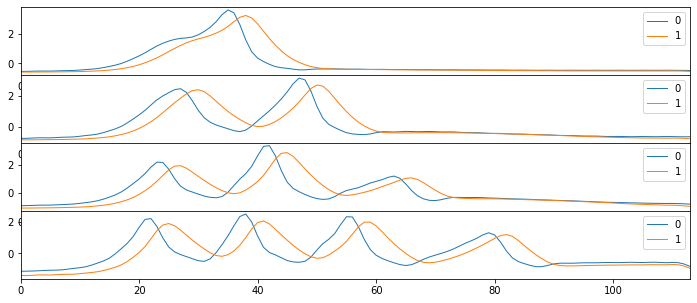

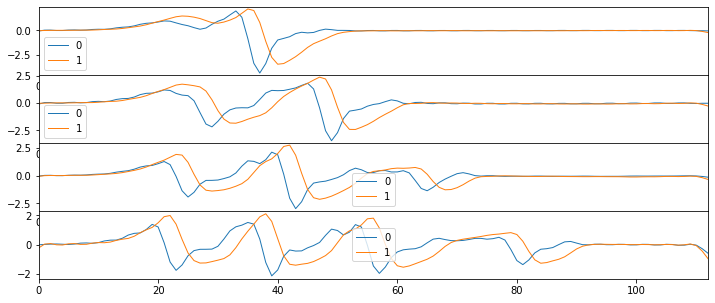

In [5]:
_ = plot_data(ds_ac_schools['std'][0])
_ = plot_data(ds_ac_schools['std-diff'][0])

As is evident from the figures above, the dataset consists of four disease dynamics with the distinguishing feature being the number of infection waves.  We would expect successful clustering to treat these are separate clusters.  Clustering one example of each dynamic won't do us any good.  Enter the remaining three datasets (i.e., those at indices of `1`, `2`, and `3`).  They contain the original four dynamics duplicated and mutated slightly via a randomized procedural method.  That method adds a time lag to each successive example as well as adds to the original signal a sine wave and a random variate.  To make it more evident, let's plot the second dataset which contains the original dynamics and a single extra variate per class.

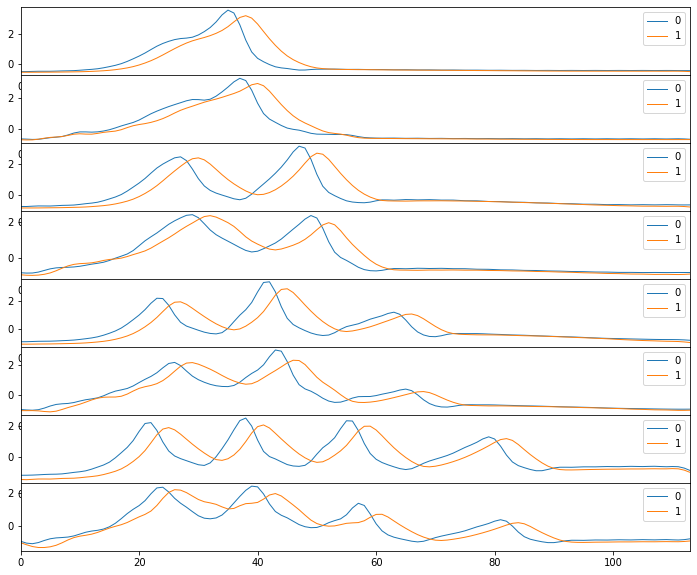

In [6]:
_ = plot_data(ds_ac_schools['std'][1])

The third dataset contains two extra variates of each class while the fourth dataset contains ten such variatess.

Let's visualize the Euclidean distance matrix for the first dataset (standardized) as well as the histogram of the values in that matrix (actually the upper triangle of it).

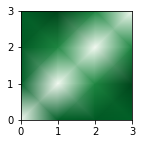

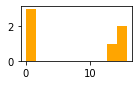

In [7]:
d = dist_mat(ds_ac_schools['std'][0])
_ = plot_dist_mat(d, (2,2), cmap='Greens')
_ = plot_dist_mat_hist(d, figsize=(2,1), color='Orange')
del(d)

Now let's go after all four datasets:

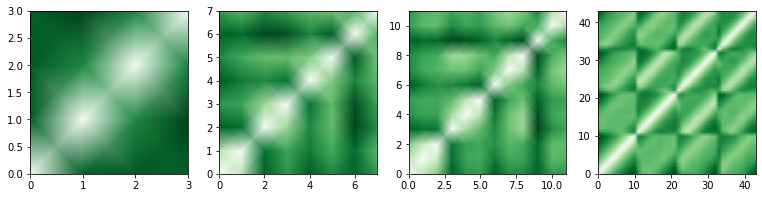

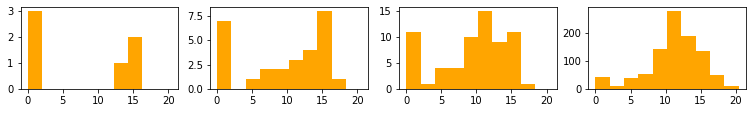

In [8]:
D = [dist_mat(ds_ac_schools['std'][i]) for i in [0,1,2,3]]
_ = plot_dist_mat_multi_col(D, (3.1, 3), wspace=0.2, cmap='Greens')
_ = plot_dist_mat_hist_multi_col(D, figsize=(3.1, 1.5), wspace=0.2, color='Orange')
del(D)

The structure of the data starts being evident.  Let's now use different distance metrics on the fourth dataset.  Intead of using only the standardized version, we also plot the differenced standardized one.

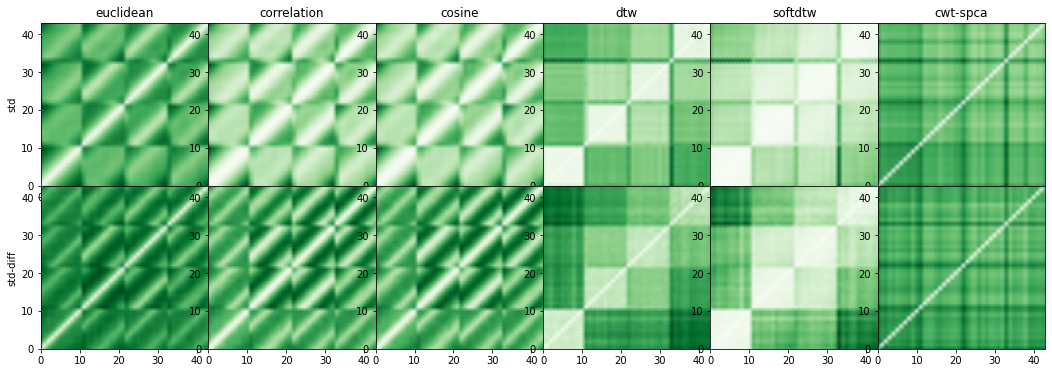

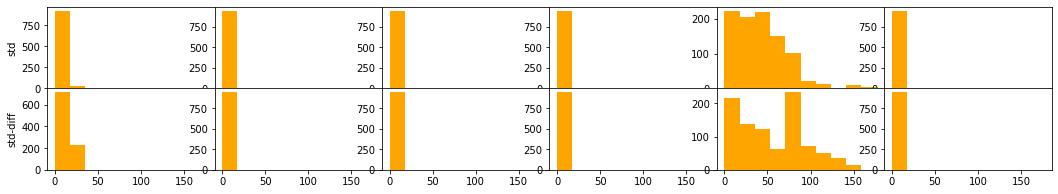

In [9]:
# M - metrics; A - datasets; T - column titles

M = ['euclidean', 'correlation', 'cosine', 'dtw', 'softdtw', 'cwt-spca']
A = [ds_ac_schools['std'][3], ds_ac_schools['std-diff'][3]]
T = ['std', 'std-diff']

D = [[dist_mat(a,m, wavelet='cmor') for m in M] for a in A]

_ = plot_dist_mat_multi_row(D, (3,3), titles=M, ylabels=T, cmap='Greens')
_ = plot_dist_mat_hist_multi_row(D, figsize=(3, 1.5), ylabels=T, color='Orange')

del(M,A,T,D)

Finally, let's investigate the effect of differnt type of mother wavelet for the SPCA.ms distance metric.

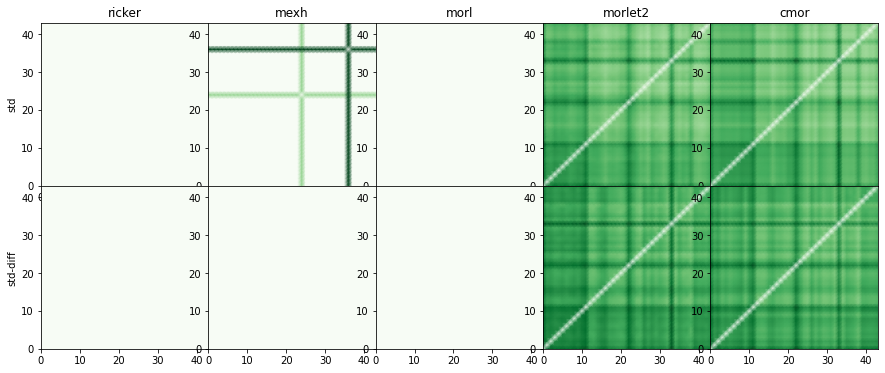

In [10]:
# W - wavelets; A - datasets; T - column titles

W = [scipy.signal.ricker, 'mexh', 'morl', scipy.signal.morlet2, 'cmor']
A = [ds_ac_schools['std'][3], ds_ac_schools['std-diff'][3]]
T = ['std', 'std-diff']

_ = plot_dist_mat_multi_row([[dist_mat(a, 'cwt-spca', wavelet=w) for w in W] for a in A], (3,3), titles=[w if isinstance(w, str) else w.__name__ for w in W], ylabels=T, cmap='Greens')

del(W,A,T)  # one does not simply plan for a meme like this, but... https://knowyourmeme.com/memes/wat

Evidently, complex wavelets work better with this kind of dataset.  We will take note for the section below.

## Observed Dynamics: Covid-19 in US Counties
---

Now, in a way analogous to the above demonstration, we visualize distance matrices for observed multivariate Covid-19 disease dynamics in five US states: Pennsylvania, New York, California, Florida, and Texas.  First, we load the data.

In [11]:
def get_data_c19(fips='42___', cols=dis_dyn, day0=0, day1=99999, do_interpolate=True, n_diff=0, smooth_window_len=14):
    return np.array(db.get_dis_dyn_by_fips(fips, cols, day0, day1, do_interpolate, n_diff, smooth_window_len, do_scale=True)[0])

ds_pa = get_data_c19('42___', smooth_window_len=14)
ds_ny = get_data_c19('36___', smooth_window_len=14)
ds_ca = get_data_c19('06___', smooth_window_len=14)
ds_fl = get_data_c19('12___', smooth_window_len=14)
ds_tx = get_data_c19('48___', smooth_window_len=14)

We use several common distance metrics and exclude soft-DTW to cut down on compute time.

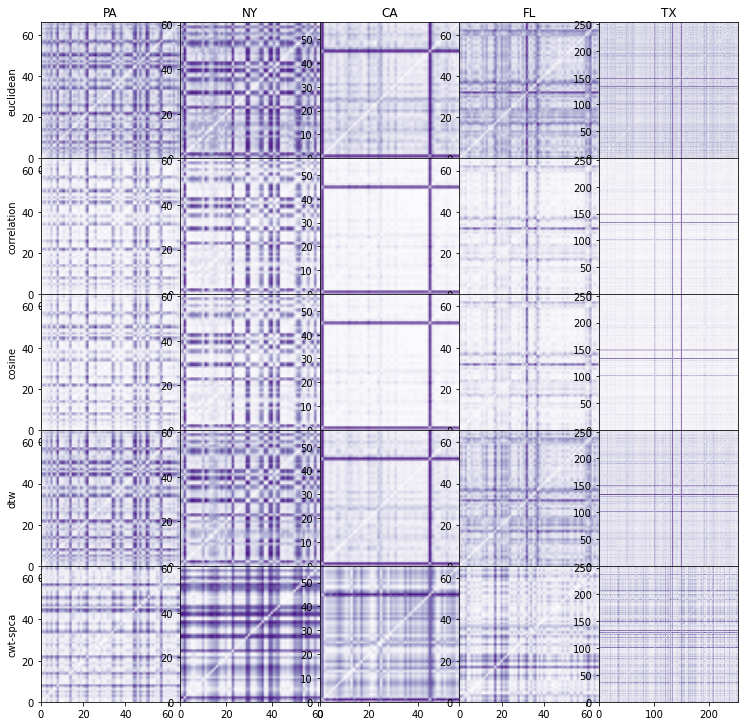

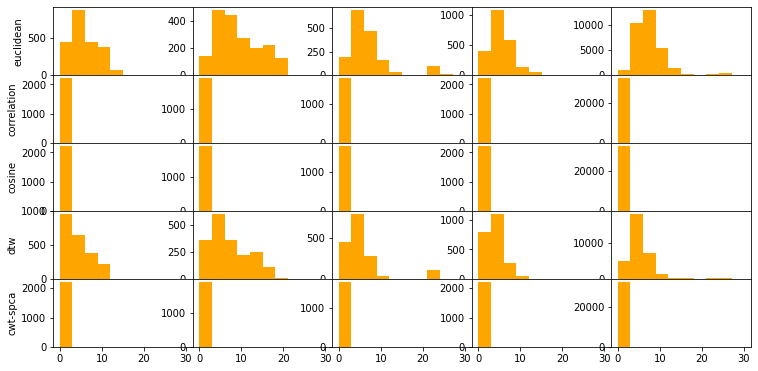

In [12]:
# M - metrics; A - datasets; T - column titles

M = ['euclidean', 'correlation', 'cosine', 'dtw', 'cwt-spca']
A = [ds_pa, ds_ny, ds_ca, ds_fl, ds_tx]
T = ['PA', 'NY', 'CA', 'FL', 'TX']

D = [[dist_mat(a,m, wavelet='cmor') for a in A] for m in M]

_ = plot_dist_mat_multi_row(D, (2.5, 2.5), titles=T, ylabels=M, cmap='Purples')
_ = plot_dist_mat_hist_multi_row(D, figsize=(2.5, 1.25), ylabels=M, color='Orange')


del(M,A,T,D)

Finally, we supplement these results with the complex Morlet CWT-based distance metric.  This computation is more computationally intensive so we crunch the numbers for the five states in parallel.  Unfortunatelly, we need to jump through some hoops to get the `multiprocessing` package work in Jupyter notebooks.  Namely, we need to import the worker function from another file (here, [workers.py](workers.py)).

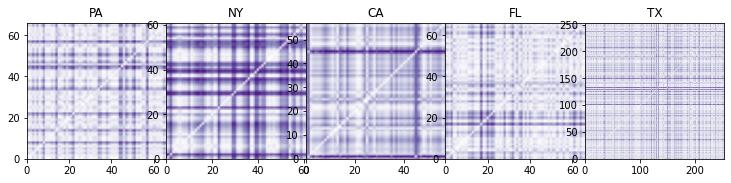

In [13]:
import workers

with mp.Pool(max(1, mp.cpu_count() - 1)) as p:
    D = p.starmap_async(workers.dist_map_worker, [[ds_pa], [ds_ny], [ds_ca], [ds_fl], [ds_tx]]).get()

_ = plot_dist_mat_multi_col(D, figsize=(2.5, 2.5), titles=['PA', 'NY', 'CA', 'FL', 'TX'], cmap='Purples')

del(workers)

We finish with a proper cleanup:

In [14]:
del(ds_ac_schools, ds_pa, ds_ny, ds_ca, ds_fl, ds_tx, db)